# CutMix, MixUp, and RandAugment image augmentation with KerasCV

**Author:** [lukewood](https://twitter.com/luke_wood_ml)<br>
**Date created:** 2022/04/08<br>
**Last modified:** 2022/04/08<br>
**Description:** Use KerasCV to augment images with CutMix, MixUp, RandAugment, and more.

## Overview

KerasCV makes it easy to assemble state-of-the-art, industry-grade data augmentation
pipelines for image classification and object detection tasks. KerasCV offers a wide
suite of preprocessing layers implementing common data augmentation techniques.

Perhaps three of the most useful layers are `keras_cv.layers.CutMix`,
`keras_cv.layers.MixUp`, and `keras_cv.layers.RandAugment`. These
layers are used in nearly all state-of-the-art image classification pipelines.

This guide will show you how to compose these layers into your own data
augmentation pipeline for image classification tasks. This guide will also walk you
through the process of customizing a KerasCV data augmentation pipeline.

## Imports & setup

This tutorial requires you to have KerasCV installed:

```shell
pip install keras-cv
```

We begin by importing all required packages:

In [1]:
pip install keras-cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import keras_cv
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import losses
from tensorflow.keras import optimizers

## Data loading

This guide uses the
[102 Category Flower Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/)
for demonstration purposes.

To get started, we first load the dataset:

In [ ]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()
data, dataset_info = tfds.load("oxford_flowers102", with_info=True, as_supervised=True)
train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
val_steps_per_epoch = dataset_info.splits["test"].num_examples // BATCH_SIZE

Dataset oxford_flowers102 downloaded and prepared to ~/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [ ]:
data, dataset_info = tfds.load("oxford_flowers102", with_info=True, as_supervised=True)

In [ ]:
data["train"]

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

Next, we resize the images to a constant size, `(224, 224)`, and one-hot encode the
labels. Please note that `keras_cv.layers.CutMix` and `keras_cv.layers.MixUp` expect
targets to be one-hot encoded. This is because they modify the values of the targets
in a way that is not possible with a sparse label representation.

In [ ]:
IMAGE_SIZE = (224, 224)
num_classes = dataset_info.features["label"].num_classes


def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, num_classes)
    return {"images": image, "labels": label}


def prepare_dataset(dataset, split):
    if split == "train":
        return (
            dataset.shuffle(10 * BATCH_SIZE)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
        )
    if split == "test":
        return dataset.map(to_dict, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)


def load_dataset(split="train"):
    dataset = data[split]
    return prepare_dataset(dataset, split)


train_dataset = load_dataset()

In [ ]:
new_samples=train_dataset.take(9)

Let's inspect some samples from our dataset:

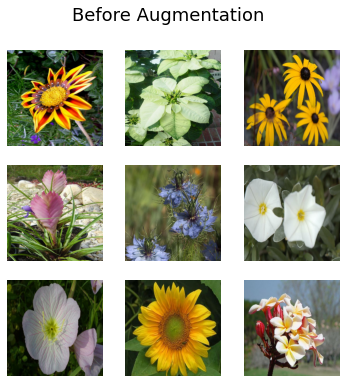

In [ ]:

def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()


visualize_dataset(train_dataset, title="Before Augmentation")

Great! Now we can move onto the augmentation step.

## RandAugment

[RandAugment](https://arxiv.org/abs/1909.13719)
has been shown to provide improved image
classification results across numerous datasets.
It performs a standard set of augmentations on an image.

To use RandAugment in KerasCV, you need to provide a few values:

- `value_range` describes the range of values covered in your images
- `magnitude` is a value between 0 and 1, describing the strength of the perturbations
applied
- `augmentations_per_image` is an integer telling the layer how many augmentations to apply to each
individual image
- (Optional) `magnitude_stddev` allows `magnitude` to be randomly sampled
from a distribution with a standard deviation of `magnitude_stddev`
- (Optional) `rate` indicates the probability to apply the augmentation
applied at each layer.

You can read more about these
parameters in the
[`RandAugment` API documentation](/api/keras_cv/layers/preprocessing/rand_augment/).

Let's use KerasCV's RandAugment implementation.

In [ ]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=0.5,
)


def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs


train_dataset = load_dataset().map(apply_rand_augment, num_parallel_calls=AUTOTUNE)

Finally, let's inspect some of the results:

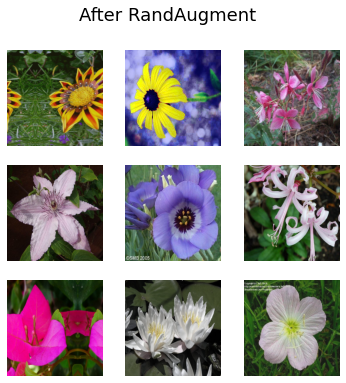

In [ ]:
visualize_dataset(train_dataset, title="After RandAugment")

Try tweaking the magnitude settings to see a wider variety of results.

## CutMix and MixUp: generate high-quality inter-class examples


`CutMix` and `MixUp` allow us to produce inter-class examples. `CutMix` randomly cuts out
portions of one image and places them over another, and `MixUp` interpolates the pixel
values between two images. Both of these prevent the model from overfitting the
training distribution and improve the likelihood that the model can generalize to out of
distribution examples. Additionally, `CutMix` prevents your model from over-relying on
any particular feature to perform its classifications. You can read more about these
techniques in their respective papers:

- [CutMix: Train Strong Classifiers](https://arxiv.org/abs/1905.04899)
- [MixUp: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)

In this example, we will use `CutMix` and `MixUp` independently in a manually created
preprocessing pipeline. In most state of the art pipelines images are randomly
augmented by either `CutMix`, `MixUp`, or neither. The function below implements both.

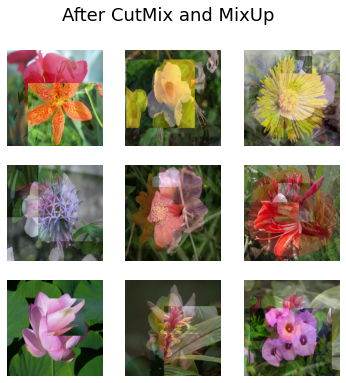

In [ ]:
cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()


def cut_mix_and_mix_up(samples):
    samples = cut_mix(samples, training=True)
    samples = mix_up(samples, training=True)
    return samples


train_dataset = load_dataset().map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)

visualize_dataset(train_dataset, title="After CutMix and MixUp")

Great! Looks like we have successfully added `CutMix` and `MixUp` to our preprocessing
pipeline.

## Customizing your augmentation pipeline

Perhaps you want to exclude an augmentation from `RandAugment`, or perhaps you want to
include the `keras_cv.layers.GridMask` as an option alongside the default `RandAugment`
augmentations.

KerasCV allows you to construct production grade custom data augmentation pipelines using
the `keras_cv.layers.RandomAugmentationPipeline` layer. This class operates similarly to
`RandAugment`; selecting a random layer to apply to each image `augmentations_per_image`
times. `RandAugment` can be thought of as a specific case of
`RandomAugmentationPipeline`. In fact, our `RandAugment` implementation inherits from
`RandomAugmentationPipeline` internally.

In this example, we will create a custom `RandomAugmentationPipeline` by removing
`RandomRotation` layers from the standard `RandAugment` policy, and substitutex a
`GridMask` layer in its place.

As a first step, let's use the helper method `RandAugment.get_standard_policy()` to
create a base pipeline.

In [ ]:
layers = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0, 255), magnitude=0.75, magnitude_stddev=0.3
)

First, let's filter out `RandomRotation` layers

In [ ]:
layers = [
    layer for layer in layers if not isinstance(layer, keras_cv.layers.RandomRotation)
]

Next, let's add `keras_cv.layers.GridMask` to our layers:

In [ ]:
layers = layers + [keras_cv.layers.GridMask()]

Finally, we can put together our pipeline

In [ ]:
pipeline = keras_cv.layers.RandomAugmentationPipeline(
    layers=layers, augmentations_per_image=3
)


def apply_pipeline(inputs):
    inputs["images"] = pipeline(inputs["images"])
    return inputs


Let's check out the results!

In [ ]:
train_dataset = load_dataset().map(apply_pipeline, num_parallel_calls=AUTOTUNE)
visualize_dataset(train_dataset, title="After custom pipeline")

Awesome! As you can see, no images were randomly rotated. You can customize the
pipeline however you like:

In [ ]:
pipeline = keras_cv.layers.RandomAugmentationPipeline(
    layers=[keras_cv.layers.GridMask(), keras_cv.layers.Grayscale(output_channels=3)],
    augmentations_per_image=1,
)

This pipeline will either apply `GrayScale` or GridMask:

In [ ]:

train_dataset = load_dataset().map(apply_pipeline, num_parallel_calls=AUTOTUNE)
visualize_dataset(train_dataset, title="After custom pipeline")

Looks great! You can use `RandomAugmentationPipeline` however you want.

## Training a CNN

As a final exercise, let's take some of these layers for a spin. In this section, we
will use `CutMix`, `MixUp`, and `RandAugment` to train a state of the art `ResNet50`
image classifier on the Oxford flowers dataset.

In [ ]:

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels


train_dataset = (
    load_dataset()
    .map(apply_rand_augment, num_parallel_calls=AUTOTUNE)
    .map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
)

visualize_dataset(train_dataset, "CutMix, MixUp and RandAugment")

train_dataset = train_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

test_dataset = load_dataset(split="test")
test_dataset = test_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.prefetch(AUTOTUNE)
test_dataset = test_dataset.prefetch(AUTOTUNE)

train_dataset = train_dataset
test_dataset = test_dataset

Next we should create a the model itself. Notice that we use `label_smoothing=0.1` in
the loss function. When using `MixUp`, label smoothing is _highly_ recommended.

In [ ]:
input_shape = IMAGE_SIZE + (3,)


def get_model():
    model = keras_cv.models.DenseNet121(
        include_rescaling=True, include_top=True, classes=num_classes
    )
    model.compile(
        loss=losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=optimizers.SGD(momentum=0.9),
        metrics=["accuracy"],
    )
    return model


Finally we train the model:

In [ ]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = get_model()
    model.fit(
        train_dataset,
        epochs=1,
        validation_data=test_dataset,
    )

## Conclusion & next steps

That's all it takes to assemble state of the art image augmentation pipeliens with
KerasCV!

As an additional exercise for readers, you can:

- Perform a hyper parameter search over the RandAugment parameters to improve the
classifier accuracy
- Substitute the Oxford Flowers dataset with your own dataset
- Experiment with custom `RandomAugmentationPipeline` objects.

Currently, between Keras core and KerasCV there are
[_28 image augmentation layers_](https://keras.io/api/keras_cv/layers/preprocessing)!
Each of these can be used independently, or in a pipeline. Check them out, and if you
find an augmentation techniques you need is missing please file a
[GitHub issue on KerasCV](https://github.com/keras-team/keras-cv/issues).

# New

In [3]:
import tensorflow as tf

In [ ]:
(images, labels), _ = tf.keras.datasets.cifar10.load_data()
labels = tf.one_hot(labels.squeeze(), 10)

cutmix = keras_cv.layers.preprocessing.cut_mix.CutMix(10)
output = cutmix({"images": images[:32], "labels": labels[:32]})

170498071/170498071 [==============================] - 11s 0us/step


In [ ]:
len(output['images'])

32

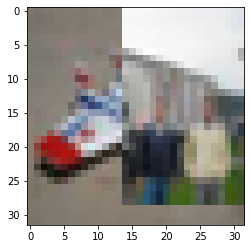

In [ ]:
plt.imshow(output['images'][30]/255)
plt.show()

In [ ]:
output['labels'][21]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.12109375, 0.87890625,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)>

In [ ]:
(images, labels), _ = tf.keras.datasets.cifar10.load_data()
labels

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [ ]:
labels[0]

array([6], dtype=uint8)

In [ ]:
labels.shape

(50000, 1)

In [ ]:
(images, labels), _ = tf.keras.datasets.cifar10.load_data()
labels = tf.one_hot(labels.squeeze(), 10)

In [ ]:
labels

<tf.Tensor: shape=(50000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
nn

<tf.Tensor: shape=(1360, 17), dtype=float32, numpy=
array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
output['labels'][0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.    , 0.    , 0.    , 0.    , 0.    , 0.0625, 0.9375, 0.    ,
       0.    , 0.    ], dtype=float32)>

In [ ]:
labelz[0]

<tf.Tensor: shape=(17,), dtype=float32, numpy=
array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [ ]:
output['labels']

In [3]:
import collections
import io
import math
import os
import random
from six.moves import urllib

from IPython.display import clear_output, Image, display, HTML

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import scipy.io
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time

In [4]:
import tarfile
import urllib
# this snippet of code is modified for our use case with additional comments, original source code:
# https://github.com/tflearn/tflearn/blob/master/tflearn/datasets/cifar10.py
def download(filename, source_url, work_directory):
    if not os.path.exists(work_directory): #check if the folder exists; if not make dir
        os.mkdir(work_directory)
    filepath = os.path.join(work_directory, filename)
    if not os.path.exists(filepath): # check if file exists; if not, download
        print("Downloading file, Please wait...")
        filepath, _ = urllib.request.urlretrieve(source_url + filename, # this is a function to download files
                                                 filepath)
        statinfo = os.stat(filepath)
        print(('Succesfully downloaded', filename, statinfo.st_size, 'bytes.'))
        untar(filepath,work_directory)
    return filepath

In [5]:
#only extract jpg files
def jpg_files(members):
    for tarinfo in members:
        if os.path.splitext(tarinfo.name)[1] == ".jpg":
            yield tarinfo

In [6]:
# extract function
def untar(fname,path="17category-flowers-py"): #untarring the archive
    tar = tarfile.open(fname)
    tar.extractall(path="17category-flowers-py", members=jpg_files(tar))
    tar.close()
    if path is "":
        print("File Extracted in Current Directory")
    else:
        print("File Extracted in to ",  path)

<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-6-21f35051e59f>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if path is "":


In [7]:
download("17flowers.tgz", "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/","17category-flowers-py")

'17category-flowers-py/17flowers.tgz'

In [8]:
os.listdir("/content/17category-flowers-py/")

['jpg', '17flowers.tgz']

In [9]:
def load_data(fpath):    
    img=Image.open(fpath).resize((224,224)) # resize to 224x224 for training purposes
    img = np.asarray(img, dtype='float32')
    return img

In [ ]:
def load_data2(fpath):    
    img=Image.open(fpath).resize((224,224)) # resize to 224x224 for training purposes
    img = np.asarray(img, dtype='float32')
    return img

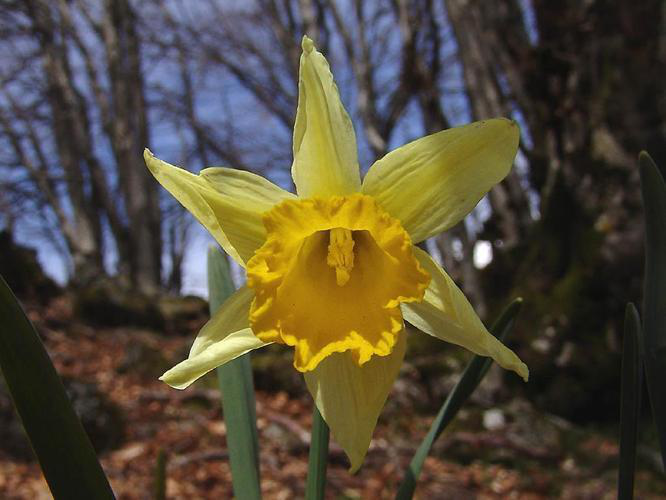

In [10]:
from PIL import Image #show one example of image
Image.open("/content/17category-flowers-py/jpg/image_0002.jpg")

In [11]:
#all images are loaded as np arrays
images=[]
labels=[]
total=1361
j=1
for i in range(1, total): 
    fname="/content/17category-flowers-py/jpg/image_"    
    fpath = os.path.join(fname + str(i).zfill(4) + ".jpg")
    images.append(load_data(fpath))
    labels.append(j) #labels are created as well
    if i%80==0: j+=1

In [87]:
images = np.asarray(images) # all of the images are converted to np array of (1360,224,224,3)
labels = np.asarray(labels).reshape(1360,1) # labels are also converted to (1360,1)
images.shape

(1360, 224, 224, 3)

In [88]:
labels=labels.ravel()

In [101]:
images = np.array(images).astype('uint8') # all of the images are converted to np array of (1360,224,224,3)
labels=np.asarray(labels).astype('uint8')
labels=labels.reshape((-1,1)) 

In [ ]:
images.shape

(1360, 224, 224, 3)

In [ ]:
labels=np.asarray(labels).astype('uint8')
labels=labels.reshape((-1,1)) 

In [ ]:
images = np.array(images).astype('uint8')
labels = np.asarray(labels).reshape(1360,1)
labels=labels.ravel()

In [ ]:
images.shape

(1360, 224, 224, 3)

In [ ]:
images=images/255.0

In [ ]:
images[0]

array([[[242, 241, 246],
        [235, 234, 239],
        [235, 234, 239],
        ...,
        [ 39,  30,  31],
        [ 60,  51,  52],
        [ 52,  43,  44]],

       [[234, 233, 238],
        [226, 225, 230],
        [224, 223, 228],
        ...,
        [ 33,  26,  26],
        [ 65,  58,  59],
        [ 66,  59,  59]],

       [[224, 224, 229],
        [214, 214, 219],
        [209, 209, 214],
        ...,
        [ 26,  21,  20],
        [ 56,  50,  50],
        [ 65,  60,  60]],

       ...,

       [[138, 132,  59],
        [137, 133,  40],
        [134, 132,  48],
        ...,
        [ 41,  51,  35],
        [ 41,  45,  34],
        [ 50,  49,  42]],

       [[132, 125,  56],
        [134, 126,  41],
        [139, 133,  48],
        ...,
        [ 39,  51,  33],
        [ 40,  44,  30],
        [ 48,  47,  37]],

       [[132, 123,  55],
        [132, 123,  40],
        [136, 129,  44],
        ...,
        [ 44,  56,  38],
        [ 48,  52,  37],
        [ 43,  42,  32]]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, labels,stratify=labels, test_size=0.2, random_state=10)

In [18]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels,train_size = 0.8, random_state =  143)
from sklearn.model_selection import train_test_split 
X_trainz, X_val, y_trainz, y_val = train_test_split(X_train, y_train, train_size = 0.95, random_state =  55)
X_val=np.concatenate((X_val, X_test), axis=0)
y_val=np.concatenate((y_val, y_test), axis=0)

In [ ]:
from sklearn.model_selection import train_test_split
import random
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels,train_size = 0.8, random_state = random.randrange(0,400,300) )
X_trainz, X_val, y_trainz, y_val = train_test_split(images, labels, train_size = random.randrange(96,98,3)/100, random_state =  random.randrange(0,400,20))
X_val=np.concatenate((X_val, X_test), axis=0)
y_val=np.concatenate((y_val, y_test), axis=0)

In [ ]:
len(X_val)

327

In [ ]:
len(X_train)

1088

In [ ]:
y_val

array([[ 7],
       [15],
       [ 6],
       [ 6],
       [ 1],
       [ 6],
       [12],
       [17],
       [10],
       [12],
       [ 9],
       [15],
       [15],
       [14],
       [ 8],
       [17],
       [ 2],
       [ 4],
       [11],
       [15],
       [ 6],
       [ 9],
       [15],
       [11],
       [ 5],
       [ 3],
       [ 5],
       [ 4],
       [14],
       [13],
       [ 7],
       [ 8],
       [ 5],
       [ 5],
       [13],
       [ 1],
       [ 7],
       [ 6],
       [ 6],
       [ 2],
       [ 5],
       [ 7],
       [15],
       [ 9],
       [11],
       [ 9],
       [16],
       [14],
       [12],
       [15],
       [17],
       [14],
       [12],
       [10],
       [14],
       [10],
       [ 1],
       [17],
       [ 4],
       [ 9],
       [ 7],
       [ 2],
       [13],
       [ 4],
       [10],
       [ 7],
       [12],
       [16],
       [ 4],
       [ 8],
       [12],
       [10],
       [11],
       [17],
       [15],
       [ 6],
       [ 3],

In [ ]:
max_len=len(images)

In [ ]:
max_len

1360

In [ ]:
labels[8]

array([1], dtype=uint8)

In [ ]:
labels

array([[ 1],
       [ 1],
       [ 1],
       ...,
       [17],
       [17],
       [17]], dtype=uint8)

In [ ]:
nn= tf.one_hot(labels.squeeze(),17)

In [ ]:
nn

<tf.Tensor: shape=(1360, 17), dtype=float32, numpy=
array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

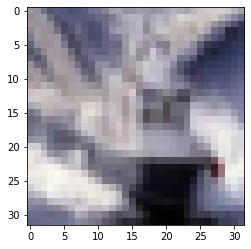

In [ ]:
plt.imshow(images[1245]/255)
plt.show()

In [ ]:
len(outputz['images'])

1311

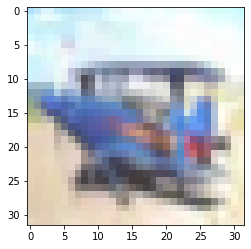

In [ ]:
plt.imshow(images[1260])
plt.show()

In [ ]:
for index in range(1280,1329):
  print(labels[index])

In [ ]:
outputz = cutmix({"images": images[1280:1311], "labels": labelz[1280:1311]})

In [ ]:
outputz['images'][3]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 68.,  91.,  65.],
        [ 70.,  93.,  67.],
        [ 71.,  94.,  68.],
        ...,
        [102., 117.,  78.],
        [102., 117.,  78.],
        [102., 117.,  78.]],

       [[ 67.,  90.,  64.],
        [ 70.,  93.,  67.],
        [ 72.,  95.,  69.],
        ...,
        [101., 116.,  77.],
        [101., 116.,  77.],
        [101., 116.,  77.]],

       [[ 66.,  89.,  63.],
        [ 70.,  93.,  67.],
        [ 73.,  96.,  70.],
        ...,
        [103., 118.,  79.],
        [103., 118.,  79.],
        [103., 118.,  79.]],

       ...,

       [[ 68., 111.,  59.],
        [ 70., 111.,  60.],
        [ 72., 113.,  62.],
        ...,
        [171., 174., 153.],
        [168., 171., 150.],
        [167., 170., 149.]],

       [[ 55., 102.,  48.],
        [ 56., 101.,  48.],
        [ 58., 102.,  48.],
        ...,
        [170., 173., 152.],
        [169., 172., 151.],
        [167., 170., 149.]],

       [[ 54., 10

In [ ]:
for index in range(31):
  plt.imshow(outputz['images'][index]/255)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Cut_Mix

In [17]:
Cut_Mix=keras_cv.layers.CutMix()
labelz = tf.one_hot(labels.squeeze(),17)
cutmix = keras_cv.layers.preprocessing.cut_mix.CutMix(10)
outputz = cutmix({"images": images[0:1360], "labels": labelz[0:1360]})
print(outputz['labels'][0])
image_list=outputz['images'].numpy()
label_list=outputz['labels'].numpy()

tf.Tensor(
[0.         0.45740992 0.         0.         0.         0.
 0.         0.         0.5425901  0.         0.         0.
 0.         0.         0.         0.         0.        ], shape=(17,), dtype=float32)


In [ ]:
mix_up = keras_cv.layers.MixUp(10)
labelz = tf.one_hot(labels.squeeze(),17)
# cutmix = keras_cv.layers.preprocessing.cut_mix.MixUp(10)
outputz = mix_up({"images": images[0:1360], "labels": labelz[0:1360]})
print(outputz['labels'][0])
image_list=outputz['images'].numpy()
label_list=outputz['labels'].numpy()

tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(17,), dtype=float32)


In [ ]:
mix_up = keras_cv.layers.MixUp(10)
labelz = tf.one_hot(labels.squeeze(),17)
# cutmix = keras_cv.layers.preprocessing.cut_mix.MixUp(10)
outputz = mix_up({"images": images[720:840], "labels": labelz[720:840]})
print(outputz['labels'][0])
image_list=outputz['images'].numpy()
label_list=outputz['labels'].numpy()

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.4896645 0.5103355 0.        0.
 0.        0.        0.       ], shape=(17,), dtype=float32)


In [ ]:
mix_up = keras_cv.layers.MixUp(10)
labelz = tf.one_hot(labels.squeeze(),17)
# cutmix = keras_cv.layers.preprocessing.cut_mix.MixUp(10)
outputz = mix_up({"images": images[790:810], "labels": labelz[790:810]})
print(outputz['labels'][0])
image_list=outputz['images'].numpy()
label_list=outputz['labels'].numpy()

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.7689768  0.23102319
 0.         0.         0.         0.         0.        ], shape=(17,), dtype=float32)


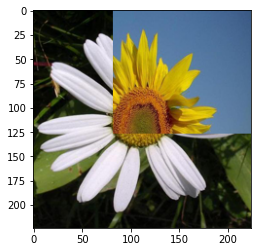

In [ ]:
plt.imshow(image_list[19]/255)

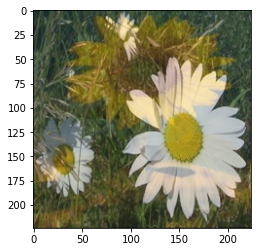

In [ ]:
plt.imshow(image_list[2]/255)

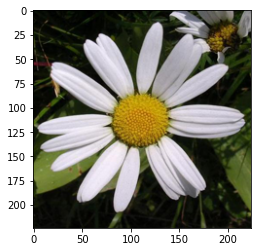

In [ ]:
plt.imshow(images[809]/255)

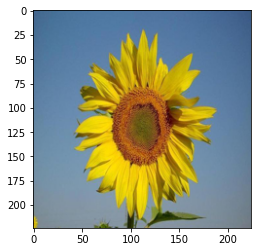

In [ ]:
plt.imshow(images[798]/255)

In [ ]:
def show(img, new_img, title1, title2):
    plt.figure(figsize = (10, 10))
    plt.subplot(1, 2, 1)
    plt.title(title1)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = plt.imshow(img, interpolation = 'bicubic')

    plt.subplot(1, 2, 2)
    plt.title(title2)
    # new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    new_img = plt.imshow(new_img, interpolation = 'bicubic')
    plt.savefig('foo.png')

In [ ]:
def show2(img,img2, new_img, title1, title2,title3):
    plt.figure(figsize = (10, 10))
    plt.subplot(1, 3, 1)
    plt.title(title1)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = plt.imshow(img, interpolation = 'bicubic')

    plt.subplot(1, 3, 2)
    plt.title(title2)
    # new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    img2 = plt.imshow(img2, interpolation = 'bicubic')
    
    plt.subplot(1, 3, 3)
    plt.title(title3)
    # new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    new_img = plt.imshow(new_img, interpolation = 'bicubic')
    plt.savefig('foo.png')

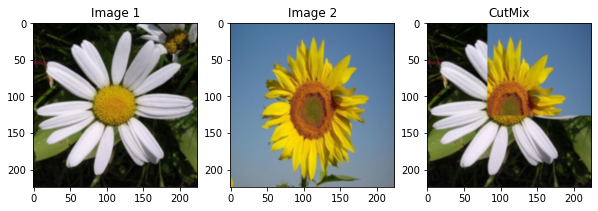

In [ ]:
show2(images[809]/255,images[798]/255,image_list[19]/255,'Image 1','Image 2','CutMix')

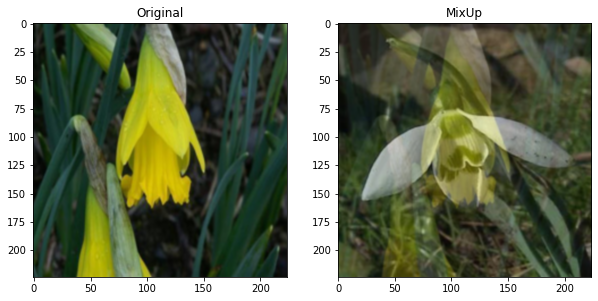

In [ ]:
show(images[44]/255,image_list[44]/255,'Original','MixUp')

In [ ]:
y_val_label = tf.one_hot(y_val.squeeze(),17)
y_train_label = tf.one_hot(y_train.squeeze(),17)

In [ ]:
Cut_Mix=keras_cv.layers.CutMix()
cutmix = keras_cv.layers.preprocessing.cut_mix.CutMix(10)
outputz = cutmix({"images": X_train[:1088], "labels": y_train_label[:1088]})
print(outputz['labels'][0])
image_list=outputz['images'].numpy()
label_list=outputz['labels'].numpy()

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.43066406 0.56933594 0.         0.         0.
 0.         0.         0.         0.         0.        ], shape=(17,), dtype=float32)


In [ ]:
train_x_dataset = np.concatenate((image_list, X_train))
train_y_dataset = np.concatenate((label_list, y_train_label))

In [ ]:
len(train_x_dataset)

2176

In [ ]:
len(image_list)

1088

In [ ]:
from skimage import feature
X_train_des=[]
for image in train_x_dataset:
  hog_desc = feature.hog(image, orientations=9, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_train_des.append(hog_desc)

In [ ]:
X_val_des=[]
for image in X_val:
  hog_desc = feature.hog(image, orientations=9, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_val_des.append(hog_desc)

In [ ]:
import cv2

In [ ]:
color_hist_train_des=[]
for image in train_x_dataset:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_train_des.append(total_hist)

In [ ]:
color_hist_val_des=[]
for image in X_val:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_val_des.append(total_hist)

In [ ]:
X_train_desc=[]
for index in range(len(color_hist_train_des)):
  nn=np.concatenate((color_hist_train_des[index], X_train_des[index]), axis=None)
  X_train_desc.append(nn)
X_val_desc=[]
for index in range(len(color_hist_val_des)):
  nn=np.concatenate((color_hist_val_des[index], X_val_des[index]), axis=None)
  X_val_desc.append(nn)

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn import datasets, svm, metrics
regr = MultiOutputRegressor(svm.SVR(kernel='rbf',gamma=2,C=1.5)).fit(X_train_desc, train_y_dataset)

In [ ]:
regr.score(X_train_desc,train_y_dataset)

0.8735851668819538

In [ ]:
regr.score(X_val_desc,y_val_label)

0.380090628416333

In [ ]:
nnn=regr.predict(X_val_desc)

In [ ]:
train_y_dataset[0]

array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.4375, 0.    , 0.5625, 0.    , 0.    , 0.    , 0.    ,
       0.    ], dtype=float32)

In [ ]:
train_y_dataset[2000]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
y_val_label[0]

<tf.Tensor: shape=(17,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [ ]:
y_val_label[3]

<tf.Tensor: shape=(17,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [ ]:
nnn[3]

array([ 0.        ,  0.07268641,  0.09600642, -0.07236549, -0.00617558,
       -0.04477641,  1.09989568, -0.03959947, -0.08869637, -0.01380396,
       -0.03691887,  0.09815176, -0.03254721, -0.00638656, -0.10007428,
        0.09930847,  0.03746925])

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [ ]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [ ]:
result=softmax(nnn)

In [ ]:
result=sigmoid(nnn)

In [ ]:
new_sum=0
for element in nnn[3]:
  new_sum=element+new_sum

In [ ]:
new_sum

1.0621738046490308

In [ ]:
y_val[0]

array([7], dtype=uint8)

In [ ]:
y_val_label[0]

<tf.Tensor: shape=(17,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [ ]:
nnn[0].shape

(17,)

In [ ]:
result[0]

array([0.5       , 0.49065617, 0.52783657, 0.50723034, 0.54076406,
       0.52748004, 0.52666389, 0.52652248, 0.56269114, 0.50701176,
       0.51074937, 0.55073661, 0.49908349, 0.49930274, 0.55637804,
       0.5178213 , 0.51163396])

In [ ]:
def find_max_index(d1d_array):
  max_value = max(d1d_array)
  new_list=d1d_array
  max_index = np.where(new_list == max_value)[0][0]
  return max_index

In [ ]:
def comparation(fi_string,se_string):
  correct=0
  for index in range(len(fi_string)):
    if(find_max_index(fi_string[index])==find_max_index(se_string[index])):
      correct=correct+1
  return correct

In [ ]:
def calcul(fi_string,se_string):
  result=comparation(fi_string,se_string)
  return result/len(fi_string)

In [ ]:
calcul(y_val_label,nnn)

0.6085626911314985

In [ ]:
print(find_max_index(result[15]))
print(find_max_index(nnn[15]))
print(find_max_index(y_val_label[15]))

16
16
0


In [ ]:
if(find_max_index(result[15])==find_max_index(y_val_label[15])):
  print('ok')

In [ ]:
max_value = max(nnn[0])
new_list=nnn[0]
max_index = np.where(new_list == max_value)[0][0]

In [ ]:
max_index

8

In [ ]:
type(max_index)

tuple

In [ ]:
predict_list=[]
for value in nnn:
  max_value = max(value)
  new_list=value
  max_index = np.where(new_list == max_value)[0][0]
  predict_list.append(max_index)

In [ ]:
type(predict_list)

list

In [ ]:
type(y_val)

numpy.ndarray

In [ ]:
max_index

(array([11]),)

In [ ]:
nn[6]

array([ 0.        ,  0.10127915,  0.10051152,  0.08712847, -0.06333997,
        0.09832105, -0.09553825, -0.02061914,  0.05436766,  0.05868529,
        0.10092651,  0.10218504,  0.89982943,  0.09866255, -0.10114789,
        0.0497249 ,  0.1015735 ])

In [ ]:
true_val=y_val.tolist()

In [ ]:
true_val=[]
for index in range(len(y_val)):
  new_value=y_val[index][0]-1
  true_val.append(new_value)

In [ ]:
len(predict_list)

272

In [ ]:
result=0
for index in range(len(true_val)):
  if (true_val[index]==predict_list[index]):
    result=result+1

In [ ]:
result

13

In [ ]:
max_value = max(predict_list)

In [ ]:
max_value

16

In [ ]:
len(true_val)

272

In [ ]:
max_value=max(true_val)

In [ ]:
max_value

16

# Mix_Up

In [ ]:
Cut_Mix=keras_cv.layers.CutMix()
labelz = tf.one_hot(labels.squeeze(),17)
cutmix = keras_cv.layers.preprocessing.cut_mix.CutMix(10)
outputz = cutmix({"images": images[0:1360], "labels": labelz[0:1360]})
print(outputz['labels'][0])
image_list=outputz['images'].numpy()
label_list=outputz['labels'].numpy()

tf.Tensor(
[0.         0.9418846  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.05811542 0.         0.        ], shape=(17,), dtype=float32)


In [ ]:
y_val_label = tf.one_hot(y_val.squeeze(),17)
y_train_label = tf.one_hot(y_train.squeeze(),17)

In [ ]:
Cut_Mix=keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp(10)
outputz = mix_up({"images": X_train[:1088], "labels": y_train_label[:1088]})
print(outputz['labels'][0])
image_list=outputz['images'].numpy()
label_list=outputz['labels'].numpy()

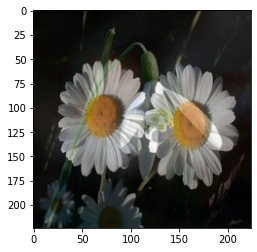

In [ ]:
plt.imshow(outputz['images'][19])
plt.show()

In [ ]:
train_x_dataset = np.concatenate((image_list, X_train))
train_y_dataset = np.concatenate((label_list, y_train_label))

In [ ]:
color_hist_train_des=[]
for image in train_x_dataset:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_train_des.append(total_hist)

In [ ]:
color_hist_val_des=[]
for image in X_val:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_val_des.append(total_hist)

In [ ]:
from skimage import feature
X_train_des=[]
for image in train_x_dataset:
  hog_desc = feature.hog(image, orientations=9, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_train_des.append(hog_desc)

In [ ]:
X_val_des=[]
for image in X_val:
  hog_desc = feature.hog(image, orientations=9, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_val_des.append(hog_desc)

In [ ]:
X_train_desc=[]
for index in range(len(color_hist_train_des)):
  nn=np.concatenate((color_hist_train_des[index], X_train_des[index]), axis=None)
  X_train_desc.append(nn)
X_val_desc=[]
for index in range(len(color_hist_val_des)):
  nn=np.concatenate((color_hist_val_des[index], X_val_des[index]), axis=None)
  X_val_desc.append(nn)

In [ ]:
len(train_x_dataset)

2176

In [ ]:
len(image_list)

1088

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn import datasets, svm, metrics
regr = MultiOutputRegressor(svm.SVR(kernel='rbf',gamma=2,C=1.5)).fit(X_train_desc, train_y_dataset)

In [ ]:
regr.score(X_train_desc,train_y_dataset)

0.8782820311062097

In [ ]:
regr.score(X_val_desc,y_val_label)

0.37424979874197406

In [ ]:
nnn=regr.predict(X_val_desc)

In [ ]:
train_y_dataset[0]

array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.4375, 0.    , 0.5625, 0.    , 0.    , 0.    , 0.    ,
       0.    ], dtype=float32)

In [ ]:
train_y_dataset[2000]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
y_val_label[0]

<tf.Tensor: shape=(17,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [ ]:
y_val_label[3]

<tf.Tensor: shape=(17,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [ ]:
nnn[3]

array([ 0.        ,  0.07268641,  0.09600642, -0.07236549, -0.00617558,
       -0.04477641,  1.09989568, -0.03959947, -0.08869637, -0.01380396,
       -0.03691887,  0.09815176, -0.03254721, -0.00638656, -0.10007428,
        0.09930847,  0.03746925])

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [ ]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [ ]:
result=softmax(nnn)

In [ ]:
result=sigmoid(nnn)

In [ ]:
new_sum=0
for element in nnn[3]:
  new_sum=element+new_sum

In [ ]:
new_sum

1.0621738046490308

In [ ]:
y_val[0]

array([7], dtype=uint8)

In [ ]:
y_val_label[0]

<tf.Tensor: shape=(17,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [ ]:
nnn[0].shape

(17,)

In [ ]:
result[0]

array([0.5       , 0.49065617, 0.52783657, 0.50723034, 0.54076406,
       0.52748004, 0.52666389, 0.52652248, 0.56269114, 0.50701176,
       0.51074937, 0.55073661, 0.49908349, 0.49930274, 0.55637804,
       0.5178213 , 0.51163396])

In [ ]:
def find_max_index(d1d_array):
  max_value = max(d1d_array)
  new_list=d1d_array
  max_index = np.where(new_list == max_value)[0][0]
  return max_index

In [ ]:
def comparation(fi_string,se_string):
  correct=0
  for index in range(len(fi_string)):
    if(find_max_index(fi_string[index])==find_max_index(se_string[index])):
      correct=correct+1
  return correct

In [ ]:
def calcul(fi_string,se_string):
  result=comparation(fi_string,se_string)
  return result/len(fi_string)

In [ ]:
calcul(y_val_label,nnn)

0.599388379204893

In [ ]:
print(find_max_index(result[15]))
print(find_max_index(nnn[15]))
print(find_max_index(y_val_label[15]))

16
16
0


In [ ]:
if(find_max_index(result[15])==find_max_index(y_val_label[15])):
  print('ok')

In [ ]:
max_value = max(nnn[0])
new_list=nnn[0]
max_index = np.where(new_list == max_value)[0][0]

In [ ]:
max_index

8

In [ ]:
type(max_index)

tuple

In [ ]:
predict_list=[]
for value in nnn:
  max_value = max(value)
  new_list=value
  max_index = np.where(new_list == max_value)[0][0]
  predict_list.append(max_index)

In [ ]:
type(predict_list)

list

In [ ]:
type(y_val)

numpy.ndarray

In [ ]:
max_index

(array([11]),)

In [ ]:
nn[6]

array([ 0.        ,  0.10127915,  0.10051152,  0.08712847, -0.06333997,
        0.09832105, -0.09553825, -0.02061914,  0.05436766,  0.05868529,
        0.10092651,  0.10218504,  0.89982943,  0.09866255, -0.10114789,
        0.0497249 ,  0.1015735 ])

In [ ]:
true_val=y_val.tolist()

In [ ]:
y_val

array([[ 7],
       [15],
       [ 6],
       [ 6],
       [ 1],
       [ 6],
       [12],
       [17],
       [10],
       [12],
       [ 9],
       [15],
       [15],
       [14],
       [ 8],
       [17],
       [ 2],
       [ 4],
       [11],
       [15],
       [ 6],
       [ 9],
       [15],
       [11],
       [ 5],
       [ 3],
       [ 5],
       [ 4],
       [14],
       [13],
       [ 7],
       [ 8],
       [ 5],
       [ 5],
       [13],
       [ 1],
       [ 7],
       [ 6],
       [ 6],
       [ 2],
       [ 5],
       [ 7],
       [15],
       [ 9],
       [11],
       [ 9],
       [16],
       [14],
       [12],
       [15],
       [17],
       [14],
       [12],
       [10],
       [14],
       [10],
       [ 1],
       [17],
       [ 4],
       [ 9],
       [ 7],
       [ 2],
       [13],
       [ 4],
       [10],
       [ 7],
       [12],
       [16],
       [ 4],
       [ 8],
       [12],
       [10],
       [11],
       [17],
       [15],
       [ 6],
       [ 3],

In [ ]:
true_val=[]
for index in range(len(y_val)):
  new_value=y_val[index][0]-1
  true_val.append(new_value)

In [ ]:
len(predict_list)

272

In [ ]:
predict_list

[8,
 16,
 6,
 6,
 5,
 6,
 12,
 9,
 10,
 8,
 9,
 9,
 15,
 7,
 12,
 16,
 2,
 4,
 11,
 5,
 6,
 9,
 15,
 16,
 5,
 8,
 5,
 5,
 14,
 11,
 7,
 10,
 5,
 5,
 13,
 1,
 7,
 6,
 6,
 4,
 5,
 7,
 9,
 9,
 11,
 4,
 14,
 7,
 7,
 12,
 16,
 7,
 13,
 10,
 1,
 12,
 1,
 16,
 7,
 5,
 7,
 5,
 13,
 3,
 10,
 14,
 10,
 16,
 8,
 14,
 12,
 10,
 11,
 8,
 15,
 16,
 9,
 11,
 6,
 14,
 6,
 16,
 3,
 7,
 11,
 15,
 12,
 13,
 16,
 16,
 12,
 9,
 13,
 10,
 8,
 5,
 16,
 5,
 5,
 7,
 12,
 2,
 2,
 11,
 5,
 12,
 10,
 14,
 11,
 9,
 15,
 9,
 12,
 9,
 8,
 1,
 8,
 6,
 13,
 5,
 13,
 14,
 6,
 7,
 5,
 11,
 9,
 11,
 6,
 3,
 8,
 2,
 12,
 5,
 16,
 2,
 6,
 12,
 8,
 12,
 5,
 10,
 9,
 9,
 5,
 16,
 8,
 10,
 13,
 6,
 4,
 12,
 1,
 6,
 5,
 5,
 5,
 14,
 16,
 12,
 10,
 2,
 12,
 13,
 10,
 14,
 2,
 15,
 1,
 3,
 11,
 12,
 1,
 5,
 10,
 8,
 12,
 9,
 16,
 2,
 10,
 5,
 8,
 16,
 5,
 9,
 15,
 10,
 11,
 7,
 14,
 9,
 12,
 9,
 8,
 3,
 12,
 4,
 15,
 14,
 2,
 1,
 8,
 11,
 16,
 2,
 10,
 11,
 15,
 5,
 8,
 9,
 16,
 7,
 12,
 14,
 4,
 5,
 10,
 15,
 3,
 6,
 15,
 12,
 

In [ ]:
true_val

[6,
 14,
 5,
 5,
 0,
 5,
 11,
 16,
 9,
 11,
 8,
 14,
 14,
 13,
 7,
 16,
 1,
 3,
 10,
 14,
 5,
 8,
 14,
 10,
 4,
 2,
 4,
 3,
 13,
 12,
 6,
 7,
 4,
 4,
 12,
 0,
 6,
 5,
 5,
 1,
 4,
 6,
 14,
 8,
 10,
 8,
 15,
 13,
 11,
 14,
 16,
 13,
 11,
 9,
 13,
 9,
 0,
 16,
 3,
 8,
 6,
 1,
 12,
 3,
 9,
 6,
 11,
 15,
 3,
 7,
 11,
 9,
 10,
 16,
 14,
 5,
 2,
 10,
 6,
 2,
 5,
 4,
 2,
 9,
 3,
 16,
 11,
 12,
 15,
 15,
 12,
 8,
 12,
 6,
 13,
 4,
 14,
 16,
 4,
 6,
 11,
 4,
 0,
 10,
 1,
 11,
 9,
 9,
 10,
 8,
 14,
 8,
 13,
 1,
 15,
 0,
 0,
 0,
 12,
 4,
 6,
 13,
 5,
 6,
 13,
 10,
 3,
 16,
 5,
 6,
 7,
 2,
 3,
 2,
 12,
 8,
 5,
 7,
 6,
 16,
 4,
 7,
 15,
 8,
 15,
 15,
 7,
 9,
 12,
 5,
 3,
 11,
 0,
 13,
 5,
 4,
 2,
 15,
 15,
 1,
 9,
 13,
 3,
 12,
 11,
 13,
 4,
 16,
 0,
 2,
 10,
 14,
 7,
 13,
 9,
 1,
 2,
 1,
 15,
 1,
 9,
 16,
 7,
 15,
 12,
 8,
 14,
 9,
 10,
 11,
 3,
 8,
 6,
 8,
 1,
 2,
 16,
 13,
 16,
 13,
 15,
 5,
 0,
 10,
 15,
 1,
 9,
 7,
 7,
 0,
 0,
 1,
 15,
 14,
 11,
 3,
 8,
 6,
 9,
 14,
 2,
 5,
 16,
 11,
 0,
 1,
 7

In [ ]:
result=0
for index in range(len(true_val)):
  if (true_val[index]==predict_list[index]):
    result=result+1

In [ ]:
result

13

In [ ]:
max_value = max(predict_list)

In [ ]:
max_value

16

In [ ]:
len(true_val)

272

In [ ]:
max_value=max(true_val)

In [ ]:
max_value

16

# RAND_AUG

In [ ]:
(x_test, y_test), _ = tf.keras.datasets.cifar10.load_data()
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255), augmentations_per_image=3, magnitude=0.5
)
x_test = rand_augment(x_test)

170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=0.5,
)


def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs

In [ ]:
aug_img = keras_cv.layers.RandAugment(value_range=(0, 255))(images[3])

In [ ]:
labels[0]

array([1], dtype=uint8)

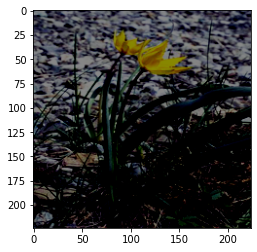

In [ ]:
plt.imshow(aug_img[0]/255)
plt.show()

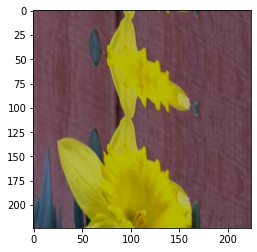

In [ ]:
plt.imshow(aug_img/255)
plt.show()

In [ ]:
labels = np.asarray(labels).reshape(1360,1)

In [89]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels,train_size = 0.8, random_state =  611)
from sklearn.model_selection import train_test_split 
X_trainz, X_val, y_trainz, y_val = train_test_split(X_train, y_train, train_size = 0.95, random_state =  74)
X_val=np.concatenate((X_val, X_test), axis=0)
y_val=np.concatenate((y_val, y_test), axis=0)

In [90]:
y_train = y_train.ravel()
y_val=y_val.ravel()

In [91]:
aug_img = keras_cv.layers.RandAugment(value_range=(0, 255),augmentations_per_image=4,magnitude=0.5,magnitude_stddev=0.15)(X_train)

In [ ]:
aug_img1 = keras_cv.layers.RandAugment(value_range=(0, 255),augmentations_per_image=4,magnitude=0.3,magnitude_stddev=0.1)(X_train)

In [ ]:
aug_img2 = keras_cv.layers.RandAugment(value_range=(0, 255),augmentations_per_image=4,magnitude=0.7,magnitude_stddev=0.15)(X_train)

In [92]:
image_list=aug_img.numpy()

In [ ]:
image_list1=aug_img1.numpy()

In [ ]:
image_list2=aug_img2.numpy()

In [93]:
X_train_30=[]
y_train_30=[]
for image in range(len(image_list)):
  X_train_30.append(image_list[image])
  X_train_30.append(X_train[image])
  y_train_30.append(y_train[image])
  y_train_30.append(y_train[image])

In [ ]:
X_train_30=[]
y_train_30=[]
for image in range(len(image_list)):
  X_train_30.append(image_list[image])
  X_train_30.append(X_train[image])
  y_train_30.append(y_train[image])
  y_train_30.append(y_train[image])
  X_train_30.append(image_list1[image])
  y_train_30.append(y_train[image])
  X_train_30.append(image_list2[image])
  y_train_30.append(y_train[image])

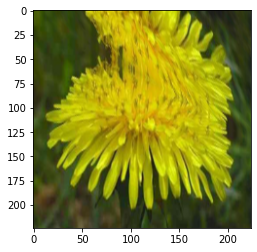

In [ ]:
plt.imshow(X_train_30[0]/255)
plt.show()

In [ ]:
X_train_30[0]

array([[[101.50018 , 101.89538 ,  99.23826 ],
        [116.69997 , 117.09515 , 114.43805 ],
        [137.80896 , 138.20416 , 135.54703 ],
        ...,
        [ 98.18279 ,  97.75722 ,  98.51424 ],
        [ 94.37544 ,  93.91709 ,  94.67412 ],
        [ 99.16896 ,  99.53138 ,  99.46764 ]],

       [[101.30202 , 101.697205,  99.007324],
        [ 98.61034 ,  99.00553 ,  95.52765 ],
        [104.2574  , 104.65259 , 101.96271 ],
        ...,
        [ 90.533745,  90.92894 ,  89.9789  ],
        [ 88.33516 ,  88.73035 ,  86.95953 ],
        [ 97.29805 ,  97.69324 ,  95.88966 ]],

       [[115.9104  , 116.33836 , 111.941414],
        [104.091995, 105.30796 , 100.12301 ],
        [100.35018 , 100.77813 ,  95.56041 ],
        ...,
        [ 95.261734,  95.65693 ,  92.99981 ],
        [ 94.27713 ,  94.672325,  92.015205],
        [104.09357 , 104.48875 , 101.831635]],

       ...,

       [[ 71.20206 ,  69.00387 ,  62.932617],
        [101.63282 ,  97.825874,  90.11309 ],
        [115.91197 , 1

In [ ]:
X_train_30[1]

array([[[127., 133., 133.],
        [151., 157., 157.],
        [168., 172., 170.],
        ...,
        [ 92.,  91.,  93.],
        [ 92.,  94.,  96.],
        [ 91.,  96., 100.]],

       [[125., 131., 131.],
        [143., 148., 147.],
        [161., 165., 164.],
        ...,
        [106., 106., 108.],
        [122., 123., 126.],
        [124., 128., 131.]],

       [[166., 170., 169.],
        [162., 166., 165.],
        [162., 166., 166.],
        ...,
        [131., 131., 133.],
        [133., 134., 136.],
        [130., 132., 134.]],

       ...,

       [[ 80.,  84.,  79.],
        [ 90.,  95.,  90.],
        [ 61.,  66.,  63.],
        ...,
        [ 48.,  62.,  34.],
        [ 76.,  87.,  59.],
        [ 69.,  80.,  50.]],

       [[ 56.,  63.,  55.],
        [ 74.,  84.,  76.],
        [ 68.,  80.,  76.],
        ...,
        [ 67.,  74.,  51.],
        [ 91.,  93.,  71.],
        [ 53.,  53.,  34.]],

       [[ 89.,  96.,  88.],
        [100., 111., 103.],
        [ 89., 1

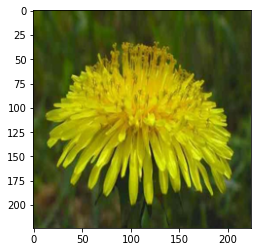

In [ ]:
plt.imshow(X_train_30[1]/255)
plt.show()

In [94]:
X_train_des=[]
X_val_des=[]
for image in X_train_30:
  hog_desc = feature.hog(image/255, orientations=8, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_train_des.append(hog_desc)
for image in X_val:
  hog_desc = feature.hog(image/255, orientations=8, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_val_des.append(hog_desc)

In [95]:
import cv2
color_hist_train_des=[]
# color_hist_val_des=[]
for image in X_train_30:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_train_des.append(total_hist)

In [96]:
color_hist_val_des=[]
for image in X_val:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_val_des.append(total_hist)

In [97]:
X_train_desc=[]
for index in range(len(color_hist_train_des)):
  nn=np.concatenate((color_hist_train_des[index], X_train_des[index]), axis=None)
  X_train_desc.append(nn)
X_val_desc=[]
for index in range(len(color_hist_val_des)):
  nn=np.concatenate((color_hist_val_des[index], X_val_des[index]), axis=None)
  X_val_desc.append(nn)

In [98]:
from sklearn import svm
clf = svm.SVC(kernel='rbf',C=1.5,gamma=2)
clf.fit(X_train_desc, y_train_30)

SVC(C=1.5, gamma=2)

In [ ]:
clf.score(X_train_desc,y_train_30)

0.9834558823529411

In [ ]:
clf.score(X_val_desc,y_val)

0.6217765042979942

In [99]:
clf.score(X_val_desc,y_val)

0.6146788990825688

In [ ]:
clf.score(X_val_desc,y_val)

0.617737003058104

In [ ]:
clf.score(X_val_desc,y_val)

0.6269113149847095

In [ ]:
clf.score(X_val_desc,y_val)

0.617737003058104

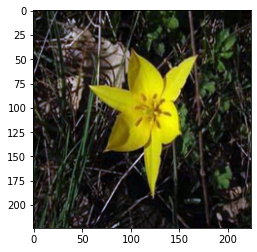

In [ ]:
plt.imshow(image_list[8]/255)
plt.show()

In [ ]:
xr = (np.argmax(y_val_label, axis=1)+1).reshape(-1, 1)
print(xr)

In [ ]:
xrr = (np.argmax(train_y_dataset, axis=1)+1).reshape(-1, 1)
print(xrr)

[[ 9]
 [ 2]
 [16]
 ...
 [ 7]
 [13]
 [ 6]]


In [ ]:
len(xrr)

2176

In [ ]:
y_val

In [ ]:
true_val=[]
for index in range(len(X_train_des)):
  true_val.append(xrr[index][0])

In [ ]:
true_val

[9,
 2,
 16,
 7,
 13,
 5,
 13,
 1,
 9,
 9,
 14,
 10,
 10,
 8,
 10,
 16,
 15,
 7,
 8,
 12,
 6,
 13,
 16,
 14,
 13,
 17,
 12,
 2,
 3,
 4,
 10,
 13,
 13,
 11,
 7,
 2,
 15,
 11,
 6,
 17,
 8,
 1,
 17,
 1,
 8,
 1,
 7,
 16,
 4,
 1,
 2,
 13,
 2,
 7,
 15,
 2,
 7,
 1,
 14,
 17,
 8,
 12,
 2,
 13,
 10,
 14,
 6,
 7,
 2,
 14,
 17,
 6,
 5,
 12,
 17,
 8,
 11,
 17,
 2,
 3,
 17,
 7,
 15,
 14,
 14,
 12,
 5,
 13,
 1,
 17,
 6,
 15,
 8,
 1,
 8,
 12,
 14,
 14,
 17,
 12,
 17,
 7,
 6,
 15,
 1,
 1,
 4,
 14,
 8,
 1,
 6,
 3,
 7,
 13,
 15,
 4,
 1,
 15,
 15,
 16,
 9,
 14,
 9,
 2,
 6,
 11,
 7,
 3,
 5,
 5,
 4,
 16,
 14,
 9,
 1,
 17,
 17,
 11,
 7,
 6,
 3,
 9,
 2,
 17,
 8,
 12,
 17,
 16,
 15,
 11,
 9,
 6,
 3,
 10,
 6,
 9,
 15,
 17,
 13,
 3,
 5,
 9,
 14,
 1,
 9,
 6,
 11,
 12,
 16,
 11,
 16,
 10,
 12,
 5,
 8,
 17,
 12,
 12,
 15,
 12,
 13,
 2,
 13,
 9,
 4,
 16,
 5,
 9,
 10,
 3,
 1,
 3,
 6,
 7,
 13,
 11,
 7,
 15,
 14,
 16,
 4,
 14,
 11,
 3,
 12,
 2,
 4,
 13,
 2,
 16,
 15,
 12,
 17,
 5,
 4,
 16,
 5,
 12,
 15,
 15,
 5,
 6,
 

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf',C=1.5,gamma=2)
clf.fit(X_train_des, true_val)

SVC(C=1.5, gamma=2)

In [ ]:
clf.score(X_train_des,true_val)

0.9618566176470589

# Rand_au and cutMix and MixUp

In [38]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=0.5,
)


def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs

In [12]:
images = np.array(images).astype('uint8')
labels=np.asarray(labels).astype('uint8')
labels=labels.reshape((-1,1)) 

In [13]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels,train_size = 0.8, random_state =  611)
from sklearn.model_selection import train_test_split 
X_trainz, X_val, y_trainz, y_val = train_test_split(X_train, y_train, train_size = 0.95, random_state =  74)
X_val=np.concatenate((X_val, X_test), axis=0)
y_val=np.concatenate((y_val, y_test), axis=0)

In [14]:
y_val_label = tf.one_hot(y_val.squeeze(),17)
y_train_label = tf.one_hot(y_train.squeeze(),17)

In [44]:
aug_img = keras_cv.layers.RandAugment(value_range=(0, 255),augmentations_per_image=4,magnitude=0.5,magnitude_stddev=0.1)(X_train)

In [16]:
image_listz=aug_img.numpy()

In [78]:
Cut_Mix=keras_cv.layers.CutMix()
cutmix = keras_cv.layers.preprocessing.cut_mix.CutMix(10)
outputz = cutmix({"images": X_train[:1088], "labels": y_train_label[:1088]})
image_list=outputz['images'].numpy()
label_list=outputz['labels'].numpy()

In [79]:
outputzz = keras_cv.layers.RandAugment(value_range=(0, 255),augmentations_per_image=4,magnitude=0.5,magnitude_stddev=0.11)(outputz)

In [80]:
image_list=outputzz['images'].numpy()
label_list=outputzz['labels'].numpy()

In [31]:
Cut_Mix=keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp(10)
outputz = mix_up({"images": X_train[:1088], "labels": y_train_label[:1088]})
print(outputz['labels'][0])
image_list=outputz['images'].numpy()
label_list=outputz['labels'].numpy()

tf.Tensor(
[0.         0.         0.         0.         0.         0.55855244
 0.         0.         0.         0.44144756 0.         0.
 0.         0.         0.         0.         0.        ], shape=(17,), dtype=float32)


In [32]:
train_x_dataset = np.concatenate((image_list, X_train,image_listz))
train_y_dataset = np.concatenate((label_list, y_train_label,y_train_label))

In [81]:
train_x_dataset = np.concatenate((image_list, X_train))
train_y_dataset = np.concatenate((label_list, y_train_label))

In [82]:
from skimage import feature
X_train_des=[]
for image in train_x_dataset:
  hog_desc = feature.hog(image, orientations=9, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_train_des.append(hog_desc)

In [83]:
X_val_des=[]
for image in X_val:
  hog_desc = feature.hog(image, orientations=9, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_val_des.append(hog_desc)

In [69]:
import cv2

In [84]:
color_hist_train_des=[]
for image in train_x_dataset:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_train_des.append(total_hist)

In [85]:
color_hist_val_des=[]
for image in X_val:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_val_des.append(total_hist)

In [86]:
X_train_desc=[]
for index in range(len(color_hist_train_des)):
  nn=np.concatenate((color_hist_train_des[index], X_train_des[index]), axis=None)
  X_train_desc.append(nn)
X_val_desc=[]
for index in range(len(color_hist_val_des)):
  nn=np.concatenate((color_hist_val_des[index], X_val_des[index]), axis=None)
  X_val_desc.append(nn)

In [87]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn import datasets, svm, metrics
regr = MultiOutputRegressor(svm.SVR(kernel='rbf',gamma=2,C=1.5)).fit(X_train_desc, train_y_dataset)

In [88]:
regr.score(X_train_desc,train_y_dataset)

0.8515962105361099

In [89]:
regr.score(X_val_desc,y_val_label)

0.37318993508567516

In [90]:
nnn=regr.predict(X_val_desc)

In [29]:
def find_max_index(d1d_array):
  max_value = max(d1d_array)
  new_list=d1d_array
  max_index = np.where(new_list == max_value)[0][0]
  return max_index
def comparation(fi_string,se_string):
  correct=0
  for index in range(len(fi_string)):
    if(find_max_index(fi_string[index])==find_max_index(se_string[index])):
      correct=correct+1
  return correct
def calcul(fi_string,se_string):
  result=comparation(fi_string,se_string)
  return result/len(fi_string)

In [30]:
calcul(nnn,y_val_label)

0.599388379204893

In [43]:
calcul(nnn,y_val_label)

0.5840978593272171

In [91]:
calcul(nnn,y_val_label)

0.5871559633027523

# Color

In [ ]:
import cv2
import copy
import random
import numpy as np
from PIL import Image, ImageOps, ImageEnhance

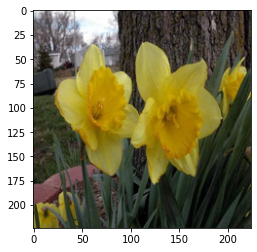

In [ ]:
plt.imshow(images[0]/255)
plt.show()

In [ ]:
new_images=[]
for element in images:
  new_image=Image.fromarray(element)
  new_images.append(new_image)

In [ ]:
def temporal_interpolate(v_list, t, n):
    if len(v_list) == 1:
        return v_list[0]
    elif len(v_list) == 2:
        return v_list[0] + (v_list[1] - v_list[0]) * t / n
    else:
        NotImplementedError('Invalid degree')

In [ ]:
def rotate(imgs, v_list=[-30, 30]):  # [-30, 30]
    for v in v_list:
        assert -30 <= v <= 30
    if random.random() > 0.5:
        v_list = [-v for v in v_list]

    out = [img.rotate(temporal_interpolate(v_list, t, len(imgs) - 1)) for t, img in enumerate(imgs)]
    return out

In [ ]:
def solarize(imgs, v_list=[130, 256]):  # [0, 256]
    for v in v_list:
        assert 0 <= v <= 256

    out = [ImageOps.solarize(img, temporal_interpolate(v_list, t, len(imgs) - 1)) for t, img in enumerate(imgs)]
    return out

In [ ]:
def color(imgs, v_list=[0.1,1.9]):  # [0.1,1.9]
    for v in v_list:
        assert 0.1 <= v <= 1.9

    out = [ImageEnhance.Color(img).enhance(temporal_interpolate(v_list, t, len(imgs) - 1)) for t, img in enumerate(imgs)]
    return out

In [ ]:
def posterize(imgs, v_list=[4, 8]):  # [4, 8]
    v_list = [max(1, int(v)) for v in v_list]

    out = [ImageOps.posterize(img, int(temporal_interpolate(v_list, t, len(imgs) - 1))) for t, img in enumerate(imgs)]
    return out

In [ ]:
def contrast(imgs, v_list=[0.2,1.8]):  # [0.1,1.9]
    for v in v_list:
        assert 0.1 <= v <= 1.9

    out = [ImageEnhance.Contrast(img).enhance(temporal_interpolate(v_list, t, len(imgs) - 1)) for t, img in enumerate(imgs)]
    return out

In [ ]:
def brightness(imgs, v_list=[0.2,1.8]):  # [0.1,1.9]
    for v in v_list:
        assert 0.1 <= v <= 1.9

    out = [ImageEnhance.Brightness(img).enhance(temporal_interpolate(v_list, t, len(imgs) - 1)) for t, img in enumerate(imgs)]
    return out

In [ ]:
def sharpness(imgs, v_list=[0.2,1.8]):  # [0.1,1.9]
    for v in v_list:
        assert 0.1 <= v <= 1.9

    out = [ImageEnhance.Sharpness(img).enhance(temporal_interpolate(v_list, t, len(imgs) - 1)) for t, img in enumerate(imgs)]
    return out

# 1

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels,train_size = 0.8, random_state =  636)
from sklearn.model_selection import train_test_split 
X_trainz, X_val, y_trainz, y_val = train_test_split(X_train, y_train, train_size = 0.95, random_state =  633)
X_val=np.concatenate((X_val, X_test), axis=0)
y_val=np.concatenate((y_val, y_test), axis=0)

In [ ]:
X_train_new=[]
X_val_new=[]
for element in X_train:
  new_image=Image.fromarray(element)
  X_train_new.append(new_image)
for element in X_val:
  new_image=Image.fromarray(element)
  X_val_new.append(new_image)

In [ ]:
X_train_30=solarize(X_train_new)

In [ ]:
X_train_20=X_train_30+X_train_new

In [ ]:
y_train_20=[]
for label in y_train:
  y_train_20.append(label)
for label in y_train:
  y_train_20.append(label)

In [ ]:
X_train_10=[]
for image in X_train_20:
  imagez = np.asarray(image)
  X_train_10.append(imagez)

In [ ]:
color_hist_train_des=[]
color_hist_val_des=[]
for image in X_train_10:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_train_des.append(total_hist)

In [ ]:
color_hist_val_des=[]
for image in X_val:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_val_des.append(total_hist)

In [ ]:
from skimage import feature
X_train_des=[]
X_val_des=[]
for image in X_train_10:
  hog_desc = feature.hog(image/255, orientations=8, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_train_des.append(hog_desc)
for image in X_val:
  hog_desc = feature.hog(image/255, orientations=8, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_val_des.append(hog_desc)

In [ ]:
X_train_desc=[]
for index in range(len(color_hist_train_des)):
  nn=np.concatenate((color_hist_train_des[index], X_train_des[index]), axis=None)
  X_train_desc.append(nn)
X_val_desc=[]
for index in range(len(color_hist_val_des)):
  nn=np.concatenate((color_hist_val_des[index], X_val_des[index]), axis=None)
  X_val_desc.append(nn)

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf',C=1.5,gamma=2)
clf.fit(X_train_desc, y_train_20)

SVC(C=1.5, gamma=2)

In [ ]:
clf.score(X_train_desc,y_train_20)

0.9986213235294118

In [ ]:
clf.score(X_val_desc,y_val)

0.5718654434250765

# 2

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels,train_size = 0.8, random_state =  77)
from sklearn.model_selection import train_test_split 
X_trainz, X_val, y_trainz, y_val = train_test_split(X_train, y_train, train_size = 0.95, random_state =  7)
X_val=np.concatenate((X_val, X_test), axis=0)
y_val=np.concatenate((y_val, y_test), axis=0)

In [ ]:
X_train_new=[]
X_val_new=[]
for element in X_train:
  new_image=Image.fromarray(element)
  X_train_new.append(new_image)
for element in X_val:
  new_image=Image.fromarray(element)
  X_val_new.append(new_image)

In [ ]:
X_train_30=color(X_train_new)

In [ ]:
X_train_20=X_train_30+X_train_new

In [ ]:
y_train_20=[]
for label in y_train:
  y_train_20.append(label)
for label in y_train:
  y_train_20.append(label)

In [ ]:
X_train_10=[]
for image in X_train_20:
  imagez = np.asarray(image)
  X_train_10.append(imagez)

In [ ]:
color_hist_train_des=[]
color_hist_val_des=[]
for image in X_train_10:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_train_des.append(total_hist)

In [ ]:
color_hist_val_des=[]
for image in X_val:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_val_des.append(total_hist)

In [ ]:
from skimage import feature
X_train_des=[]
X_val_des=[]
for image in X_train_10:
  hog_desc = feature.hog(image/255, orientations=8, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_train_des.append(hog_desc)
for image in X_val:
  hog_desc = feature.hog(image/255, orientations=8, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_val_des.append(hog_desc)

In [ ]:
X_train_desc=[]
for index in range(len(color_hist_train_des)):
  nn=np.concatenate((color_hist_train_des[index], X_train_des[index]), axis=None)
  X_train_desc.append(nn)
X_val_desc=[]
for index in range(len(color_hist_val_des)):
  nn=np.concatenate((color_hist_val_des[index], X_val_des[index]), axis=None)
  X_val_desc.append(nn)

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf',C=1.5,gamma=2)
clf.fit(X_train_desc, y_train_20)

SVC(C=1.5, gamma=2)

In [ ]:
clf.score(X_train_desc,y_train_20)

1.0

In [ ]:
clf.score(X_val_desc,y_val)

0.6055045871559633

# 3

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels,train_size = 0.8, random_state =  55)
from sklearn.model_selection import train_test_split 
X_trainz, X_val, y_trainz, y_val = train_test_split(X_train, y_train, train_size = 0.95, random_state =  33)
X_val=np.concatenate((X_val, X_test), axis=0)
y_val=np.concatenate((y_val, y_test), axis=0)

In [ ]:
X_train_new=[]
X_val_new=[]
for element in X_train:
  new_image=Image.fromarray(element)
  X_train_new.append(new_image)
for element in X_val:
  new_image=Image.fromarray(element)
  X_val_new.append(new_image)

In [ ]:
X_train_30=posterize(X_train_new)

In [ ]:
X_train_20=X_train_30+X_train_new

In [ ]:
y_train_20=[]
for label in y_train:
  y_train_20.append(label)
for label in y_train:
  y_train_20.append(label)

In [ ]:
X_train_10=[]
for image in X_train_20:
  imagez = np.asarray(image)
  X_train_10.append(imagez)

In [ ]:
color_hist_train_des=[]
color_hist_val_des=[]
for image in X_train_10:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_train_des.append(total_hist)

In [ ]:
color_hist_val_des=[]
for image in X_val:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_val_des.append(total_hist)

In [ ]:
from skimage import feature
X_train_des=[]
X_val_des=[]
for image in X_train_10:
  hog_desc = feature.hog(image/255, orientations=8, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_train_des.append(hog_desc)
for image in X_val:
  hog_desc = feature.hog(image/255, orientations=8, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_val_des.append(hog_desc)

In [ ]:
X_train_desc=[]
for index in range(len(color_hist_train_des)):
  nn=np.concatenate((color_hist_train_des[index], X_train_des[index]), axis=None)
  X_train_desc.append(nn)
X_val_desc=[]
for index in range(len(color_hist_val_des)):
  nn=np.concatenate((color_hist_val_des[index], X_val_des[index]), axis=None)
  X_val_desc.append(nn)

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf',C=1.5,gamma=2)
clf.fit(X_train_desc, y_train_20)

SVC(C=1.5, gamma=2)

In [ ]:
clf.score(X_train_desc,y_train_20)

0.9981617647058824

In [ ]:
clf.score(X_val_desc,y_val)

0.581039755351682

# 4

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels,train_size = 0.8, random_state =  77)
from sklearn.model_selection import train_test_split 
X_trainz, X_val, y_trainz, y_val = train_test_split(X_train, y_train, train_size = 0.95, random_state =  7)
X_val=np.concatenate((X_val, X_test), axis=0)
y_val=np.concatenate((y_val, y_test), axis=0)

In [ ]:
X_train_new=[]
X_val_new=[]
for element in X_train:
  new_image=Image.fromarray(element)
  X_train_new.append(new_image)
for element in X_val:
  new_image=Image.fromarray(element)
  X_val_new.append(new_image)

In [ ]:
X_train_30=contrast(X_train_new)

In [ ]:
X_train_20=X_train_30+X_train_new

In [ ]:
y_train_20=[]
for label in y_train:
  y_train_20.append(label)
for label in y_train:
  y_train_20.append(label)

In [ ]:
X_train_10=[]
for image in X_train_20:
  imagez = np.asarray(image)
  X_train_10.append(imagez)

In [ ]:
color_hist_train_des=[]
color_hist_val_des=[]
for image in X_train_10:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_train_des.append(total_hist)

In [ ]:
color_hist_val_des=[]
for image in X_val:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_val_des.append(total_hist)

In [ ]:
from skimage import feature
X_train_des=[]
X_val_des=[]
for image in X_train_10:
  hog_desc = feature.hog(image/255, orientations=8, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_train_des.append(hog_desc)
for image in X_val:
  hog_desc = feature.hog(image/255, orientations=8, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_val_des.append(hog_desc)

In [ ]:
X_train_desc=[]
for index in range(len(color_hist_train_des)):
  nn=np.concatenate((color_hist_train_des[index], X_train_des[index]), axis=None)
  X_train_desc.append(nn)
X_val_desc=[]
for index in range(len(color_hist_val_des)):
  nn=np.concatenate((color_hist_val_des[index], X_val_des[index]), axis=None)
  X_val_desc.append(nn)

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf',C=1.5,gamma=2)
clf.fit(X_train_desc, y_train_20)

SVC(C=1.5, gamma=2)

In [ ]:
clf.score(X_train_desc,y_train_20)

1.0

In [ ]:
clf.score(X_val_desc,y_val)

0.6055045871559633

# 5

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels,train_size = 0.8, random_state =  77)
from sklearn.model_selection import train_test_split 
X_trainz, X_val, y_trainz, y_val = train_test_split(X_train, y_train, train_size = 0.95, random_state =  7)
X_val=np.concatenate((X_val, X_test), axis=0)
y_val=np.concatenate((y_val, y_test), axis=0)

In [ ]:
X_train_new=[]
X_val_new=[]
for element in X_train:
  new_image=Image.fromarray(element)
  X_train_new.append(new_image)
for element in X_val:
  new_image=Image.fromarray(element)
  X_val_new.append(new_image)

In [ ]:
X_train_30=brightness(X_train_new)

In [ ]:
X_train_20=X_train_30+X_train_new

In [ ]:
y_train_20=[]
for label in y_train:
  y_train_20.append(label)
for label in y_train:
  y_train_20.append(label)

In [ ]:
X_train_10=[]
for image in X_train_20:
  imagez = np.asarray(image)
  X_train_10.append(imagez)

In [ ]:
color_hist_train_des=[]
color_hist_val_des=[]
for image in X_train_10:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_train_des.append(total_hist)

In [ ]:
color_hist_val_des=[]
for image in X_val:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_val_des.append(total_hist)

In [ ]:
from skimage import feature
X_train_des=[]
X_val_des=[]
for image in X_train_10:
  hog_desc = feature.hog(image/255, orientations=8, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_train_des.append(hog_desc)
for image in X_val:
  hog_desc = feature.hog(image/255, orientations=8, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_val_des.append(hog_desc)

In [ ]:
X_train_desc=[]
for index in range(len(color_hist_train_des)):
  nn=np.concatenate((color_hist_train_des[index], X_train_des[index]), axis=None)
  X_train_desc.append(nn)
X_val_desc=[]
for index in range(len(color_hist_val_des)):
  nn=np.concatenate((color_hist_val_des[index], X_val_des[index]), axis=None)
  X_val_desc.append(nn)

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf',C=1.5,gamma=2)
clf.fit(X_train_desc, y_train_20)

SVC(C=1.5, gamma=2)

In [ ]:
clf.score(X_train_desc,y_train_20)

0.9995404411764706

In [ ]:
clf.score(X_val_desc,y_val)

0.5871559633027523

# 6

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels,train_size = 0.8, random_state =  77)
from sklearn.model_selection import train_test_split 
X_trainz, X_val, y_trainz, y_val = train_test_split(X_train, y_train, train_size = 0.95, random_state =  7)
X_val=np.concatenate((X_val, X_test), axis=0)
y_val=np.concatenate((y_val, y_test), axis=0)

In [ ]:
X_train_new=[]
X_val_new=[]
for element in X_train:
  new_image=Image.fromarray(element)
  X_train_new.append(new_image)
for element in X_val:
  new_image=Image.fromarray(element)
  X_val_new.append(new_image)

In [ ]:
X_train_30=sharpness(X_train_new)

In [ ]:
X_train_20=X_train_30+X_train_new

In [ ]:
y_train_20=[]
for label in y_train:
  y_train_20.append(label)
for label in y_train:
  y_train_20.append(label)

In [ ]:
X_train_10=[]
for image in X_train_20:
  imagez = np.asarray(image)
  X_train_10.append(imagez)

In [ ]:
color_hist_train_des=[]
color_hist_val_des=[]
for image in X_train_10:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_train_des.append(total_hist)

In [ ]:
color_hist_val_des=[]
for image in X_val:
  hist1 = cv2.calcHist([image],[0],None,[32],[0,256])
  new_hist1=hist1/np.sum(hist1)
  hist2 = cv2.calcHist([image],[1],None,[32],[0,256])
  new_hist2=hist2/np.sum(hist2)
  hist3 = cv2.calcHist([image],[2],None,[32],[0,256])
  new_hist3=hist3/np.sum(hist3)
  total_hist=np.concatenate((new_hist1,new_hist2,new_hist3), axis=None)
  color_hist_val_des.append(total_hist)

In [ ]:
from skimage import feature
X_train_des=[]
X_val_des=[]
for image in X_train_10:
  hog_desc = feature.hog(image/255, orientations=8, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_train_des.append(hog_desc)
for image in X_val:
  hog_desc = feature.hog(image/255, orientations=8, pixels_per_cell=(28, 28), cells_per_block=(8, 8), transform_sqrt=True, block_norm='L2-Hys')
  X_val_des.append(hog_desc)

In [ ]:
X_train_desc=[]
for index in range(len(color_hist_train_des)):
  nn=np.concatenate((color_hist_train_des[index], X_train_des[index]), axis=None)
  X_train_desc.append(nn)
X_val_desc=[]
for index in range(len(color_hist_val_des)):
  nn=np.concatenate((color_hist_val_des[index], X_val_des[index]), axis=None)
  X_val_desc.append(nn)

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf',C=1.5,gamma=2)
clf.fit(X_train_desc, y_train_20)

SVC(C=1.5, gamma=2)

In [ ]:
clf.score(X_train_desc,y_train_20)

1.0

In [ ]:
clf.score(X_val_desc,y_val)

0.6024464831804281